In [1]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

# 2. Derive models

## 2.1 Define symbolic variables

Define states.

In [2]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# drone position in tracker frame
p_x_t, p_y_t, p_z_t = sym.symbols('p_x^T, p_y^T, p_z^T')

# distance to drone (state)
r_s = sym.Symbol('r_s')

Define inputs.

In [3]:
# gyroscope measurements - components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

Define outputs.

In [4]:
n_x, n_y, r, d = sym.symbols('n_x, n_y, r, d')

Define parameters.

In [5]:
g, k_flow = sym.symbols('g, k_flow')

Create the linear velocity vector $v^B_{W, B}$ and the angular velocity vector $w^B_{W, B}$, both written in the coordinates of the body frame.

In [6]:
v_inB_ofWB = sym.Matrix([v_x, v_y, v_z])
w_inB_ofWB = sym.Matrix([w_x, w_y, w_z])
P_inT_ofB = sym.Matrix([p_x_t, p_y_t, p_z_t])

## 2.2 Define kinematics of orientation

### 2.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [7]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame $B$ in the coordinates of frame $W$).

In [8]:
R_inW_ofB = Rz * Ry * Rx

### 2.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{W, B}^{B}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [9]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [11]:
N = sym.simplify(Ninv.inv())

## 2.3 Derive equations of motion

Define $a^\text{SF}$, i.e., "acceleration without the gravity term."

In [12]:
aSF = sym.Matrix([
    w_inB_ofWB.cross(v_inB_ofWB)[0],
    w_inB_ofWB.cross(v_inB_ofWB)[1],
    a_z,
])

Define $\dot{P}_B^T$, assuming $v_T^W = 0$

In [13]:
Pdot_inT_ofB = R_inW_ofB * v_inB_ofWB

Define $\dot{r}$

In [63]:
r_s_dot = Pdot_inT_ofB.dot(P_inT_ofB) / r_s
r_s_dot

(p_x^T*(v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))) + p_y^T*(v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))) + p_z^T*(-v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)))/r_s

Create equations of motion.

In [46]:
f = sym.Matrix.vstack(
    R_inW_ofB * v_inB_ofWB,
    N * w_inB_ofWB,
    R_inW_ofB.T * sym.Matrix([0, 0, - g]) + aSF,
    Pdot_inT_ofB,
    sym.Matrix([r_s_dot])
)

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ p_x^T \\ p_y^T \\ p_z^T \\ r\end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

In [47]:
f

Matrix([
[                                                                                                                                                                                                                                                 v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[                                                                                                                                                                                                                                                v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                                                                                                                                                                                  

## 2.4 Derive measurement equations

Create measurement equations.

In [48]:
h = sym.Matrix([
    k_flow * (v_x - p_z * w_y) / p_z,         # <-- x flow (n_x)
    k_flow * (v_y + p_z * w_x) / p_z,         # <-- y flow (n_y)
    p_z / (sym.cos(phi) * sym.cos(theta)),    # <-- z range (r)
    r_s                                       # <-- distance (d)
])

Show measurement equations, which have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} n_x \\ n_y \\ r \\ d\end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ p_x^T \\ p_y^T \\ p_z^T \\ r \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

In [49]:
h

Matrix([
[k_flow*(-p_z*w_y + v_x)/p_z],
[ k_flow*(p_z*w_x + v_y)/p_z],
[  p_z/(cos(phi)*cos(theta))],
[                        r_s]])

# 3. Derive state-space model

## 3.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ — along with constant parameters $p_\text{eq}$ — for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a symbolic variable to describe the equilibrium value of $p_z$.

In [50]:
p_z_eq = sym.symbols('p_z_eq')
r_s_eq = sym.symbols('r_eq')

Create a list of states, inputs, outputs, and parameters as symbolic variables.

In [51]:
s = [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, p_x_t, p_y_t, p_z_t, r_s]
i = [w_x, w_y, w_z, a_z]
o = [n_x, n_y, r, d]
p = [g, k_flow]

Create a list of state and input values at equilibrium in the **same order** as before.

In [52]:
s_eq = [0, 0, p_z_eq, 0, 0, 0, 0, 0, 0, 0, 0, 0, r_s_eq]
i_eq = [0, 0, 0, g]

Make sure all equilibrium values are symbolic.

In [53]:
s_eq = [sym.nsimplify(a) for a in s_eq]
i_eq = [sym.nsimplify(a) for a in i_eq]

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be a matrix of zeros:

In [54]:
f.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

## 3.2 Find $A$, $B$, $C$, and $D$

Recall that:

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
C = \frac{\partial h}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
D = \frac{\partial h}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

Compute each Jacobian and plug in the equilibrium values as follows.

In [55]:
A = f.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
B = f.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
C = h.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
D = h.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show $A$:

In [57]:
A

Matrix([
[0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, g,  0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, -g, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0]])

Show $B$:

In [58]:
B

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 1],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0]])

Show $C$:

In [59]:
C

Matrix([
[0, 0, 0, 0, 0, 0, k_flow/p_z_eq,             0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,             0, k_flow/p_z_eq, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0,             0,             0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0,             0,             0, 0, 0, 0, 0, 1]])

Show $D$ (note that it is *not* zero in this case):

In [60]:
D

Matrix([
[     0, -k_flow, 0, 0],
[k_flow,       0, 0, 0],
[     0,       0, 0, 0],
[     0,       0, 0, 0]])

## 3.3 Write linearized models

Define the state, input, and output of the state-space system (i.e., the linearized model of the equations of motion and of the measurement equations).

In [61]:
x = sym.Matrix(s) - sym.Matrix(s_eq)
u = sym.Matrix(i) - sym.Matrix(i_eq)
y = sym.Matrix(o) - h.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show the linearized equations of motion $Ax+Bu$.

In [62]:
A * x + B * u

Matrix([
[    v_x],
[    v_y],
[    v_z],
[    w_z],
[    w_y],
[    w_x],
[g*theta],
[ -g*phi],
[a_z - g],
[    v_x],
[    v_y],
[    v_z],
[      0]])

Show the linearized measurement equations $Cx+Du$.

In [64]:
C * x + D * u

Matrix([
[-k_flow*w_y + k_flow*v_x/p_z_eq],
[ k_flow*w_x + k_flow*v_y/p_z_eq],
[                   p_z - p_z_eq],
[                    -r_eq + r_s]])

Show the output (which our model tells us should be $Cx+Du$).

In [65]:
y

Matrix([
[        n_x],
[        n_y],
[-p_z_eq + r],
[   d - r_eq]])

In [66]:
subs = {g: 9.81, k_flow: 0.01 * 30.0 / np.deg2rad(4.2), p_z_eq: 0.5, r_s_eq: 1.}

A = np.array(A.subs(subs).evalf()).astype(np.float64)
B = np.array(B.subs(subs).evalf()).astype(np.float64)
C = np.array(C.subs(subs).evalf()).astype(np.float64)
D = np.array(D.subs(subs).evalf()).astype(np.float64)

## 2.2 Show that not all states are observable

Find the observability matrix

$$ W_o = \begin{bmatrix} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{bmatrix} $$

where $A$ is $n \times n$.

In [67]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

W_o = obsv(A, C)

Find the rank of the observability matrix using [numpy.linalg.matrix_rank](https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html). The system is **observable** if and only if $W_o$ is **full rank**, that is, if its rank is equal to the number of states $n$.

In [68]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A.shape[0]}')
# print(f"W_o: \n{W_o}\n")
W_str = np.array2string(W_o,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)
# print(W_str)

      rank of W_o is: 7
"full rank" would be: 13


In [69]:
from scipy.linalg import null_space
ns = null_space(W_o)
ns = ns * np.copysign(1, ns[0, 0])
print(np.array2string(ns, formatter={"float_kind": lambda x: f'{x:12.6f}'},
                prefix='    ',
                max_line_width=np.inf))

[[    0.000000     0.000000     0.000000     0.000000     1.000000     0.000000]
     [   -1.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000    -1.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     1.000000     0.000000     0.000000     0.000000]
     [    0.000000     0.000000     0.000000     1.000000     0.000000     0.000000]
     [    0.000000     1.000000     0.000000     0.000000     0.00000

If the system is *not* observable, then it is impossible to design a stable observer - that is, an observer that makes the error in your estimate of each state converge to zero over time.

In particular, the following code would produce an error if you tried to use it:
```python
# Choose weights
Q = np.eye(3) # <-- one diagonal entry for each output
R = np.eye(9) # <-- one diagonal entry for each state

# Find gain matrix
L = lqr(A.T, C.T, linalg.inv(R), linalg.inv(Q)).T
```
It does not matter what method you use - if it is impossible to design a stable observer, that's it, you're out of luck!

## 2.3 Choose a subset of states that are observable

List the index of each state to include.

In [70]:
s_obs_index = [
    2, # p_z
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
    12 # r_s
]

Define a state-space model

$$
\begin{align*}
\dot{x}_\text{obs} = A_\text{obs} x_\text{obs} + B_\text{obs} u \\
y = C_\text{obs} x_\text{obs} + D_\text{obs} u
\end{align*}
$$

with only these states.

In [71]:
A_obs = A[s_obs_index, :][:, s_obs_index]
B_obs = B[s_obs_index, :]
C_obs = C[:, s_obs_index]
D_obs = D

Show the matrices that describe this state-space model.

In [72]:
print(f'A_obs:\n{A_obs}\n')
print(f'B_obs:\n{B_obs}\n')
print(f'C_obs:\n{C_obs}\n')
print(f'D_obs:\n{D_obs}\n')

A_obs:
[[ 0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    9.81  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -9.81  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]

B_obs:
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

C_obs:
[[0.         0.         0.         8.18511136 0.         0.
  0.        ]
 [0.         0.         0.         0.         8.18511136 0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]]

D_obs:
[[ 0.         -4.09255568  0.          0.        ]
 [ 4.09255568  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]



Check that this subsystem is observable:

In [73]:
print(f'      rank of W_o is: {np.linalg.matrix_rank(obsv(A_obs, C_obs))}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 7
"full rank" would be: 7


## 2.4 Choose gain matrix for the observable subsystem

### 2.4.1 With equal weights

Choose weights $Q$ and $R$ as identity matrices.

In [74]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [75]:
# FIXME: change the size of each identity matrix to match the
# number of states and outputs for your observable subsystem

Q = np.eye(4) # <-- one diagonal entry for each output
R = np.eye(7) # <-- one diagonal entry for each state

Find gain matrix $L$ for the chosen $Q$ and $R$ by solving an LQR problem.

In [76]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R), linalg.inv(Q)).T

Show $L$ (formatted nicely).

In [77]:
L_str = np.array2string(L,
                        formatter={'float_kind': lambda x: f'{x:12.6f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'L = {L_str}')

L = [[   -0.000000     0.000000     1.732051     0.000000]
     [    1.000000    -0.000000     0.000000     0.000000]
     [   -0.000000    -1.000000     0.000000    -0.000000]
     [    1.843105     0.000000    -0.000000    -0.000000]
     [    0.000000     1.843105     0.000000    -0.000000]
     [   -0.000000     0.000000     1.000000     0.000000]
     [   -0.000000    -0.000000     0.000000     1.000000]]


# 4. Error Analysis of $d$ and $P_B^T$

Load flight data.

In [49]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('calibration_default_obs_varying_height.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
# data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from when the drone was actually flying
only_in_flight(data_drone)

Parse flight data.

In [58]:
# Drone data
# time
t = data_drone['time']
# states
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']
v_x = data_drone['ae483log.v_x']
v_y = data_drone['ae483log.v_y']
v_z = data_drone['ae483log.v_z']
# inputs
w_x = data_drone['ae483log.w_x']
w_y = data_drone['ae483log.w_y']
w_z = data_drone['ae483log.w_z']
a_z = data_drone['ae483log.a_z']
# outputs
n_x = data_drone['ae483log.n_x']
n_y = data_drone['ae483log.n_y']
r = data_drone['ae483log.r']
d = data_drone['ae483log.d']

Find time step (should be 0.01).

In [59]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


Define numerical values of each parameter. **Modify the text in this cell** to justify your choice of $p_{z,\text{eq}}$.

In [79]:
# Acceleration of gravity
g = 9.81

# Optical flow constant (do not modify)
k_flow = 0.01 * 30.0 / np.deg2rad(4.2)

# Equilibrium value of p_z
p_z_eq = 0.5

r_s_eq = 1.

## 4.2 Error in linearized equations of motion

### 4.2.1 Error in linear model of $\dot{p}_x$

Approximate $\dot{p}_x$ by finite difference and call this "ground truth."

In [86]:
p_x_dot_true = (p_x[1:] - p_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `p_x_dot_true` is one less than the length of `p_x` (and of `t`):

In [87]:
print(f'len(p_x_dot_true) = {len(p_x_dot_true)}')
print(f'         len(p_x) = {len(p_x)}')
print(f'           len(t) = {len(t)}')

len(p_x_dot_true) = 3969
         len(p_x) = 3970
           len(t) = 3970


Predict $\dot{p}_x$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is

$$ \dfrac{d}{dt}\left( p_x - p_{x,\text{eq}} \right) = \dot{p}_x, $$

and that the first element of $Ax+Bu$ is $v_x$. So, our state-space model tells us that $\dot{p}_x \approx v_x$.

In [88]:
p_x_dot_predicted = v_x

Compare the true value and the predicted values of $\dot{p}_x$ in a plot.

Text(0.5, 0, 'time (s)')

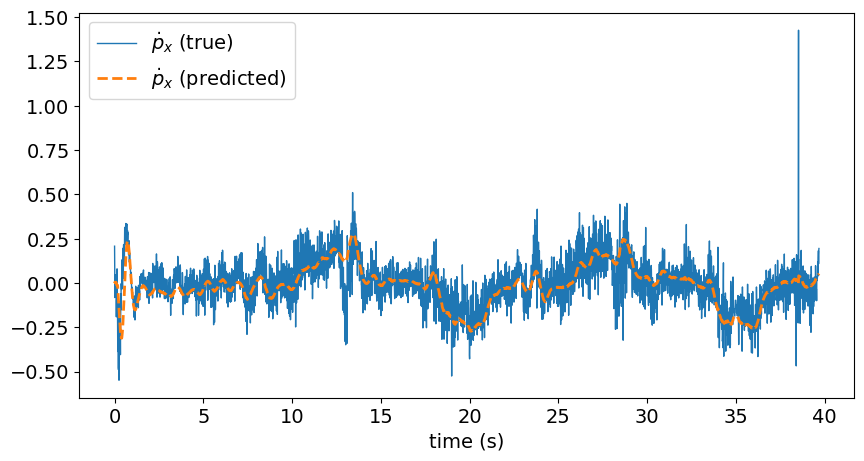

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], p_x_dot_true, label=r'$\dot{p}_x$ (true)', linewidth=1)
ax.plot(t, p_x_dot_predicted, '--', label=r'$\dot{p}_x$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{p}_x$\n(mean = -0.014, std =  0.096)')

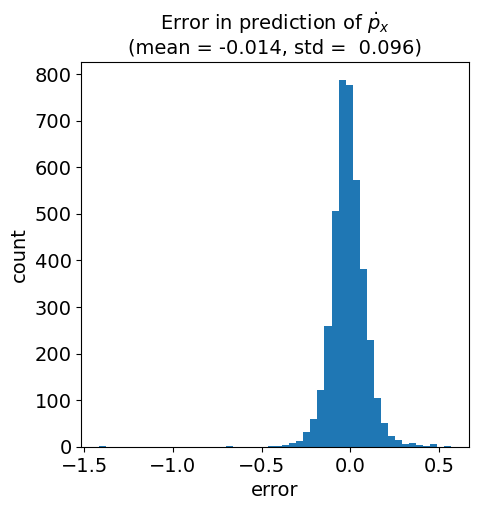

In [115]:
p_x_dot_err = p_x_dot_predicted[:-1] - p_x_dot_true

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(p_x_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{p}_x$' +
    f'\n(mean = {np.mean(p_x_dot_err):6.3f}, std = {np.std(p_x_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.2 Error in linear model of $\dot{p}_y$

In [62]:
p_y_dot_true = (p_y[1:] - p_y[:-1]) / dt
p_y_dot_predicted = v_y
p_y_dot_err = p_y_dot_predicted[:-1] - p_y_dot_true

Text(0.5, 0, 'time (s)')

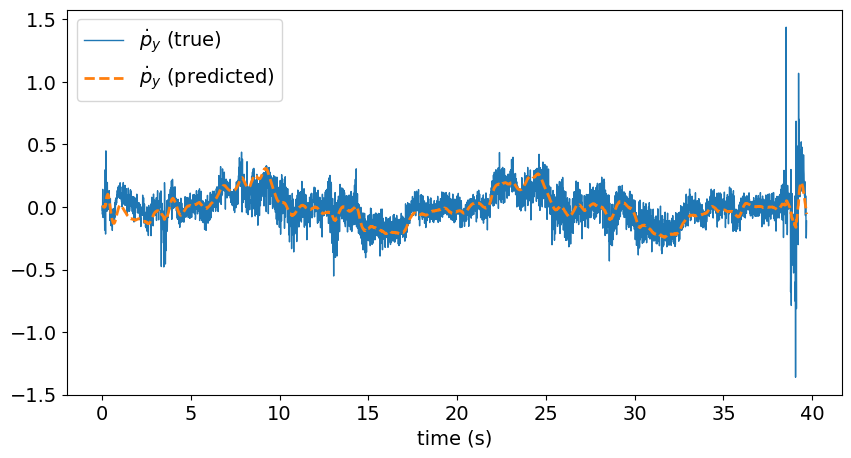

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], p_y_dot_true, label=r'$\dot{p}_y$ (true)', linewidth=1)
ax.plot(t, p_y_dot_predicted, '--', label=r'$\dot{p}_y$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{p}_y$\n(mean = -0.011, std =  0.107)')

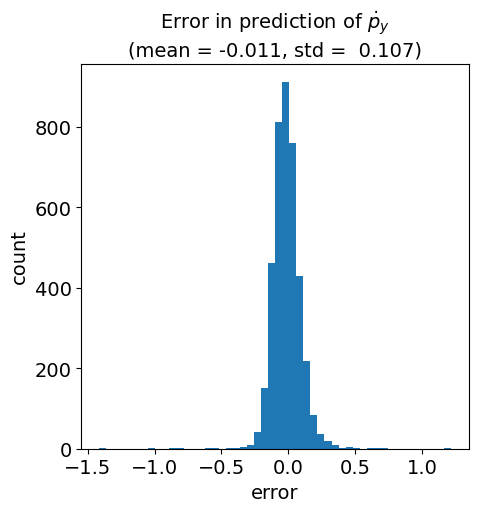

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(p_y_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{p}_y$' +
    f'\n(mean = {np.mean(p_y_dot_err):6.3f}, std = {np.std(p_y_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.3 Error in linear model of $\dot{p}_z$

In [65]:
p_z_dot_true = (p_z[1:] - p_z[:-1]) / dt
p_z_dot_predicted = v_z
p_z_dot_err = p_z_dot_predicted[:-1] - p_z_dot_true

Text(0.5, 0, 'time (s)')

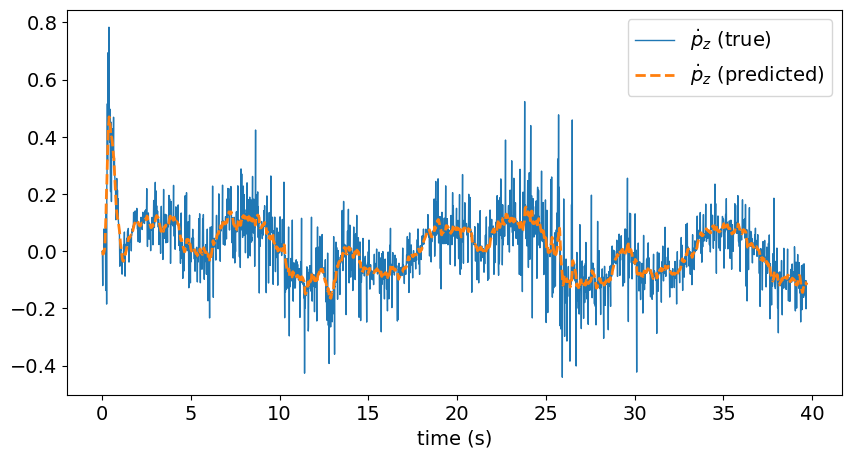

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], p_z_dot_true, label=r'$\dot{p}_z$ (true)', linewidth=1)
ax.plot(t, p_z_dot_predicted, '--', label=r'$\dot{p}_z$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{p}_z$\n(mean =  0.002, std =  0.060)')

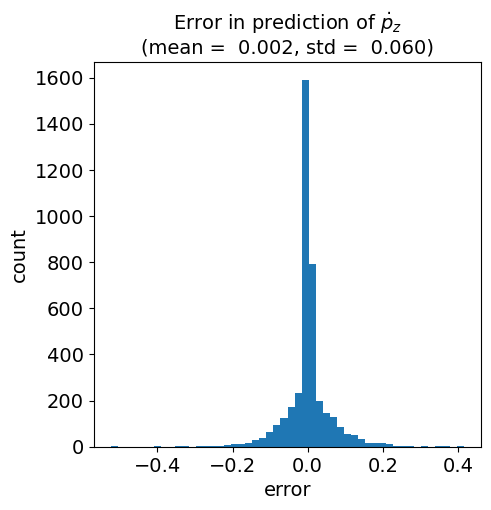

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(p_z_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{p}_z$' +
    f'\n(mean = {np.mean(p_z_dot_err):6.3f}, std = {np.std(p_z_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.4 Error in linear model of $\dot{\psi}$

In [68]:
psi_dot_true = (psi[1:] - psi[:-1]) / dt
psi_dot_predicted = w_z
psi_dot_err = psi_dot_predicted[:-1] - psi_dot_true

Text(0.5, 0, 'time (s)')

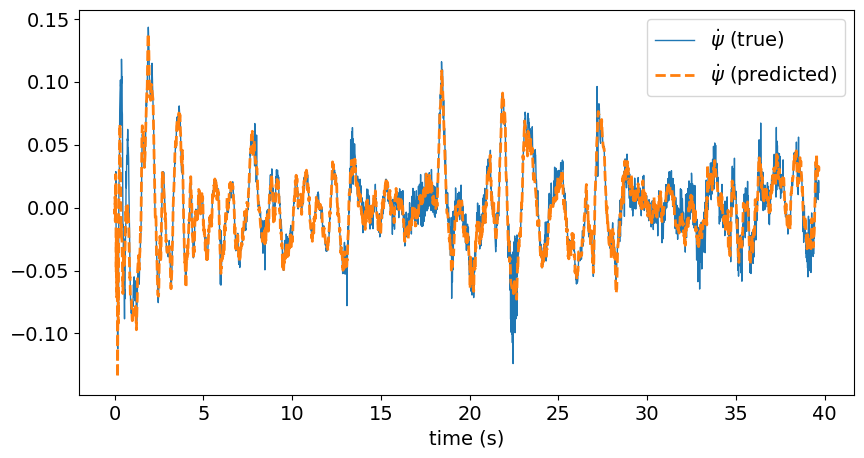

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], psi_dot_true, label=r'$\dot{\psi}$ (true)', linewidth=1)
ax.plot(t, psi_dot_predicted, '--', label=r'$\dot{\psi}$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{\\psi}$\n(mean = -0.001, std =  0.011)')

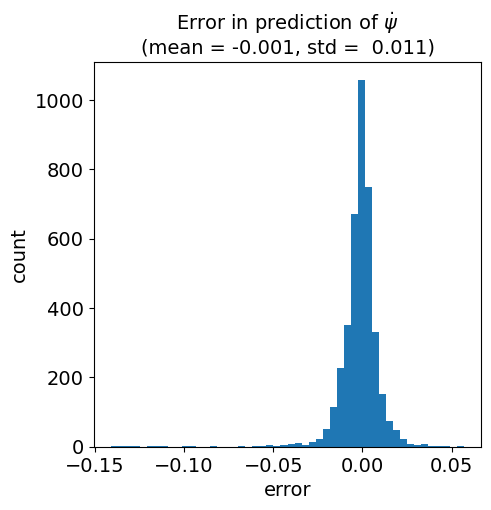

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(psi_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{\psi}$' +
    f'\n(mean = {np.mean(psi_dot_err):6.3f}, std = {np.std(psi_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.5 Error in linear model of $\dot{\theta}$

In [71]:
theta_dot_true = (theta[1:] - theta[:-1]) / dt
theta_dot_predicted = w_y
theta_dot_err = theta_dot_predicted[:-1] - theta_dot_true

Text(0.5, 0, 'time (s)')

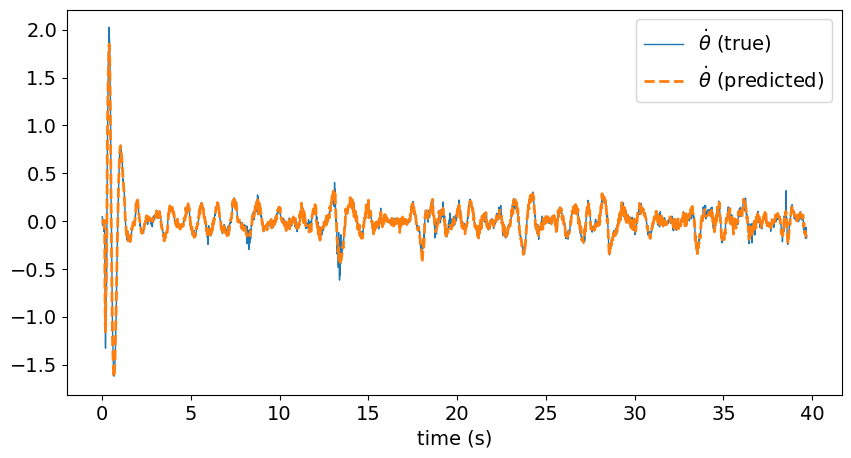

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], theta_dot_true, label=r'$\dot{\theta}$ (true)', linewidth=1)
ax.plot(t, theta_dot_predicted, '--', label=r'$\dot{\theta}$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{\\theta}$\n(mean = -0.000, std =  0.031)')

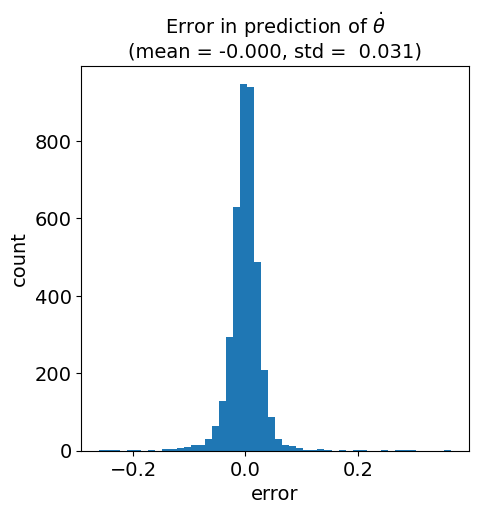

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(theta_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{\theta}$' +
    f'\n(mean = {np.mean(theta_dot_err):6.3f}, std = {np.std(theta_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.6 Error in linear model of $\dot{\phi}$

In [74]:
phi_dot_true = (phi[1:] - phi[:-1]) / dt
phi_dot_predicted = w_x
phi_dot_err = phi_dot_predicted[:-1] - phi_dot_true

Text(0.5, 0, 'time (s)')

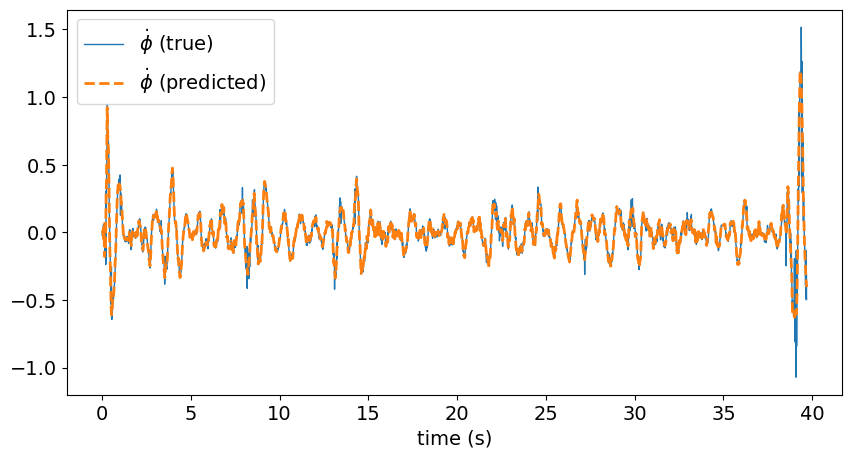

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], phi_dot_true, label=r'$\dot{\phi}$ (true)', linewidth=1)
ax.plot(t, phi_dot_predicted, '--', label=r'$\dot{\phi}$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{\\phi}$\n(mean =  0.000, std =  0.036)')

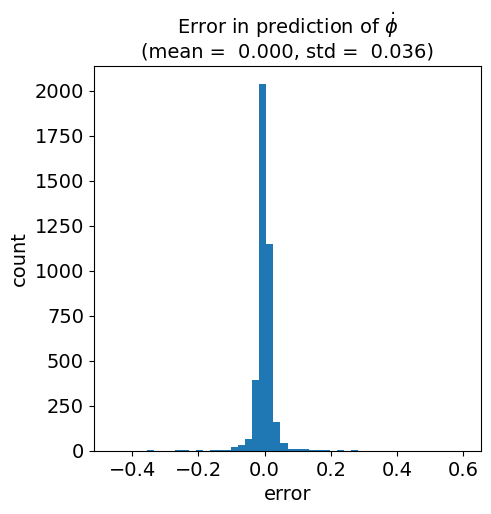

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(phi_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{\phi}$' +
    f'\n(mean = {np.mean(phi_dot_err):6.3f}, std = {np.std(phi_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.7 Error in linear model of $\dot{v}_x$

In [77]:
v_x_dot_true = (v_x[1:] - v_x[:-1]) / dt
v_x_dot_predicted = g * theta
v_x_dot_err = v_x_dot_predicted[:-1] - v_x_dot_true

Text(0.5, 0, 'time (s)')

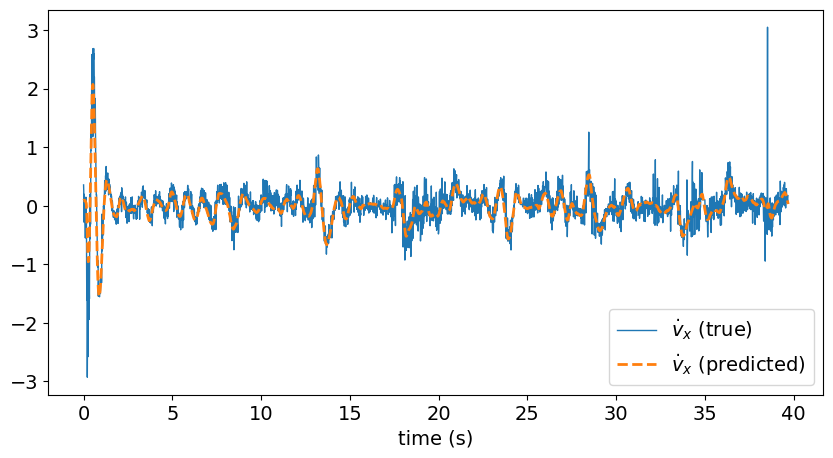

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], v_x_dot_true, label=r'$\dot{v}_x$ (true)', linewidth=1)
ax.plot(t, v_x_dot_predicted, '--', label=r'$\dot{v}_x$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{v}_x$\n(mean = -0.011, std =  0.174)')

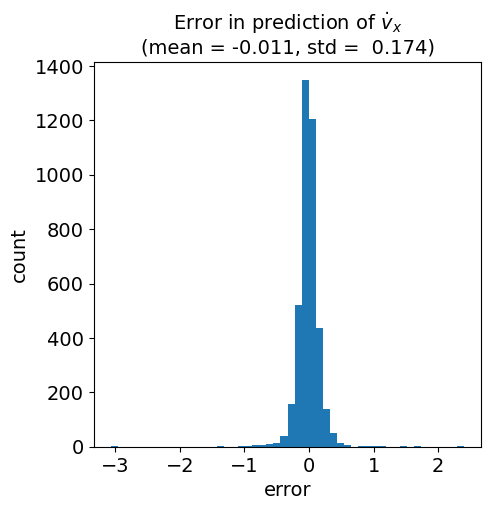

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(v_x_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{v}_x$' +
    f'\n(mean = {np.mean(v_x_dot_err):6.3f}, std = {np.std(v_x_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.8 Error in linear model of $\dot{v}_y$

In [80]:
v_y_dot_true = (v_y[1:] - v_y[:-1]) / dt
v_y_dot_predicted = -g * phi
v_y_dot_err = v_y_dot_predicted[:-1] - v_y_dot_true

Text(0.5, 0, 'time (s)')

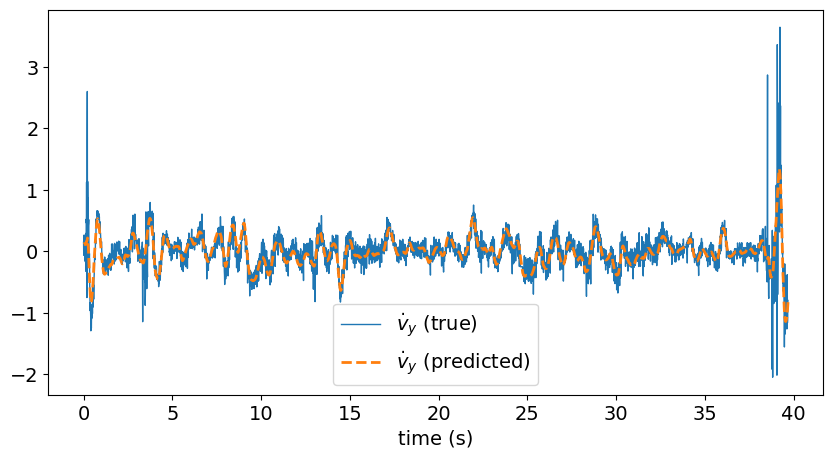

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], v_y_dot_true, label=r'$\dot{v}_y$ (true)', linewidth=1)
ax.plot(t, v_y_dot_predicted, '--', label=r'$\dot{v}_y$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{v}_y$\n(mean = -0.009, std =  0.192)')

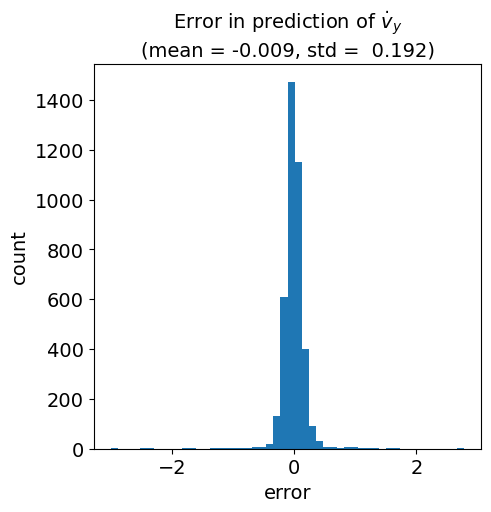

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(v_y_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{v}_y$' +
    f'\n(mean = {np.mean(v_y_dot_err):6.3f}, std = {np.std(v_y_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.9 Error in linear model of $\dot{v}_z$

In [83]:
v_z_dot_true = (v_z[1:] - v_z[:-1]) / dt
v_z_dot_predicted = a_z - g
v_z_dot_err = v_z_dot_predicted[:-1] - v_z_dot_true

Text(0.5, 0, 'time (s)')

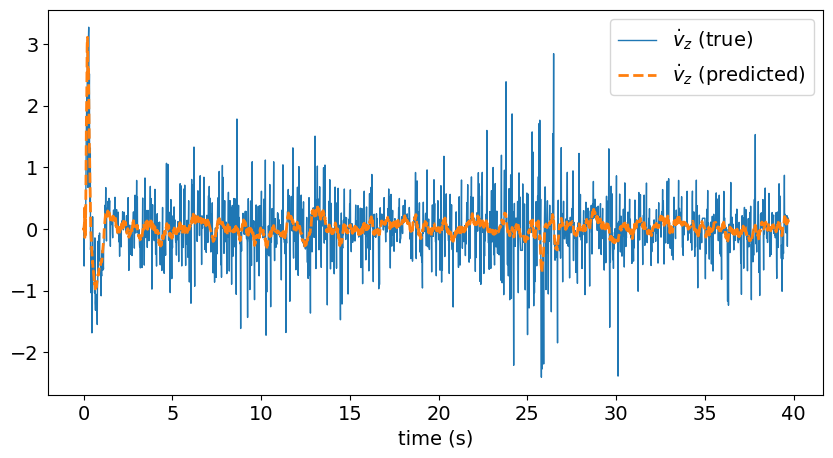

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], v_z_dot_true, label=r'$\dot{v}_z$ (true)', linewidth=1)
ax.plot(t, v_z_dot_predicted, '--', label=r'$\dot{v}_z$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $\\dot{v}_z$\n(mean =  0.016, std =  0.323)')

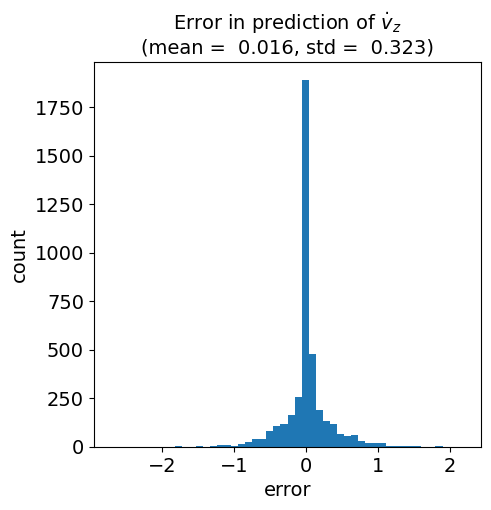

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(v_z_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{v}_z$' +
    f'\n(mean = {np.mean(v_z_dot_err):6.3f}, std = {np.std(v_z_dot_err):6.3f})',
    fontsize=14,
)

### 4.3.1 Error in linear model of $n_x$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{p_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{p_\text{z, eq}} - w_y \right).$$

In [97]:
n_x_predicted = k_flow * ((v_x / p_z_eq) - w_y)

Compare the true value and the predicted values of $n_x$ in a plot.

Text(0.5, 0, 'time (s)')

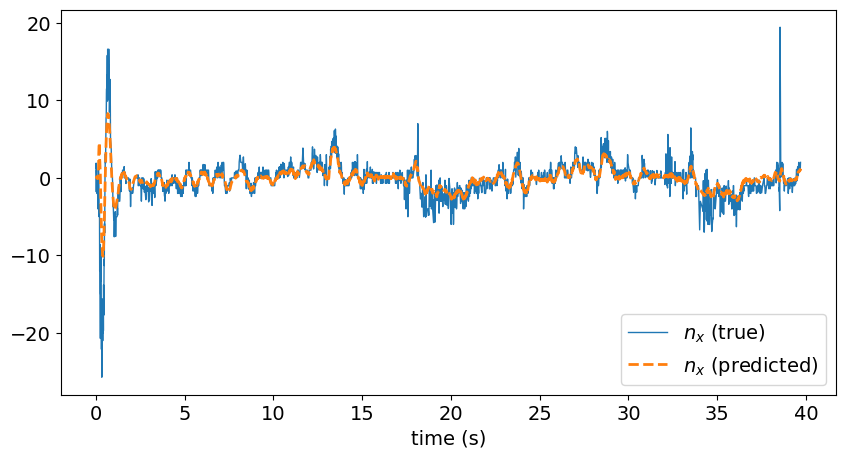

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, n_x, label=r'$n_x$ (true)', linewidth=1)
ax.plot(t, n_x_predicted, '--', label=r'$n_x$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [99]:
n_x_err = n_x_predicted - n_x

Plot a histogram of the error, showing mean and standard deviation.

Text(0.5, 1.0, 'Error in prediction of $n_x$\n(mean =  0.159, std =  1.473)')

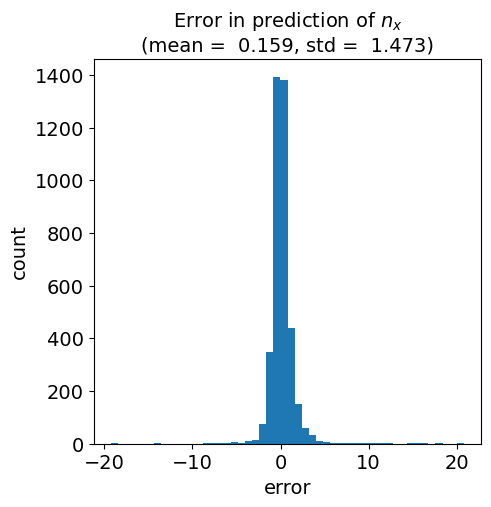

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(n_x_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $n_x$' +
    f'\n(mean = {np.mean(n_x_err):6.3f}, std = {np.std(n_x_err):6.3f})',
    fontsize=14,
)

### 4.3.2 Error in linear model of $n_y$

In [101]:
n_y_predicted = k_flow * ((v_y / p_z_eq) + w_y)
n_y_err = n_y_predicted - n_y

Text(0.5, 0, 'time (s)')

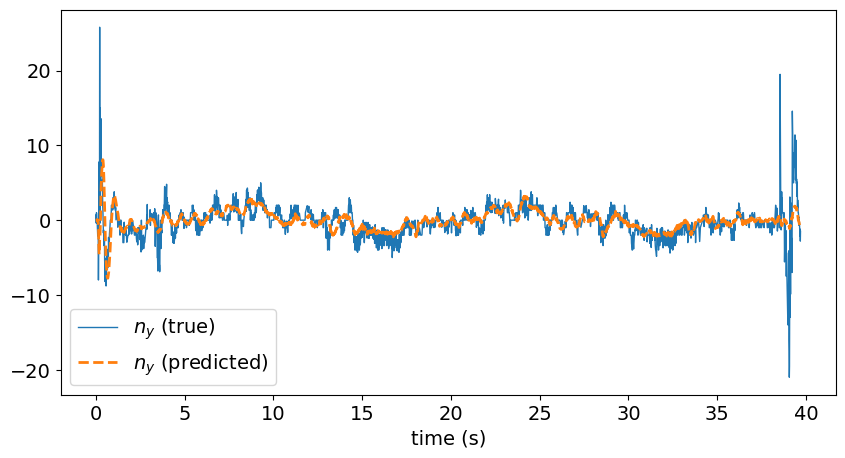

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, n_y, label=r'$n_y$ (true)', linewidth=1)
ax.plot(t, n_y_predicted, '--', label=r'$n_y$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $n_y$\n(mean =  0.123, std =  1.776)')

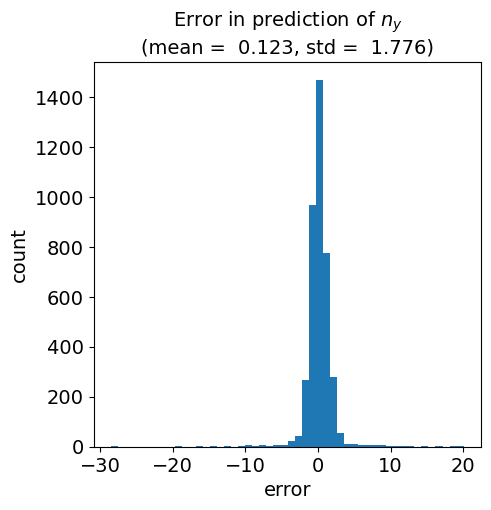

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(n_y_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $n_y$' +
    f'\n(mean = {np.mean(n_y_err):6.3f}, std = {np.std(n_y_err):6.3f})',
    fontsize=14,
)

### 4.3.3 Error in linear model of $r$

In [104]:
r_predicted = p_z
r_err = r_predicted - r

Text(0.5, 0, 'time (s)')

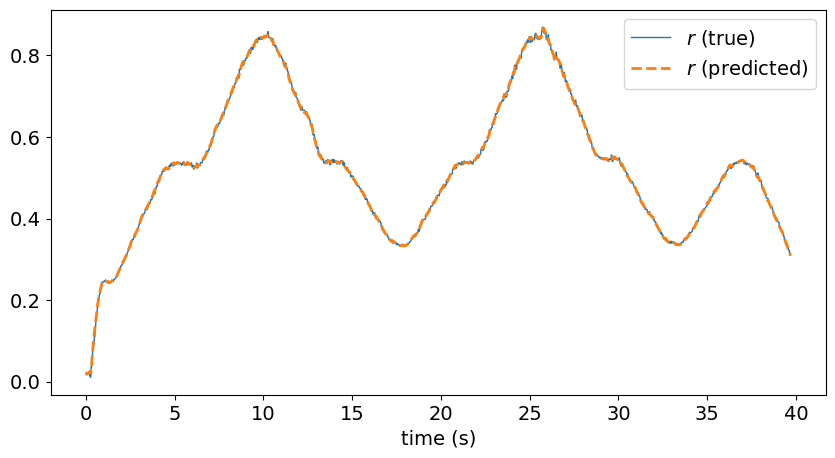

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, r, label=r'$r$ (true)', linewidth=1)
ax.plot(t, r_predicted, '--', label=r'$r$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $r$\n(mean =  0.000, std =  0.003)')

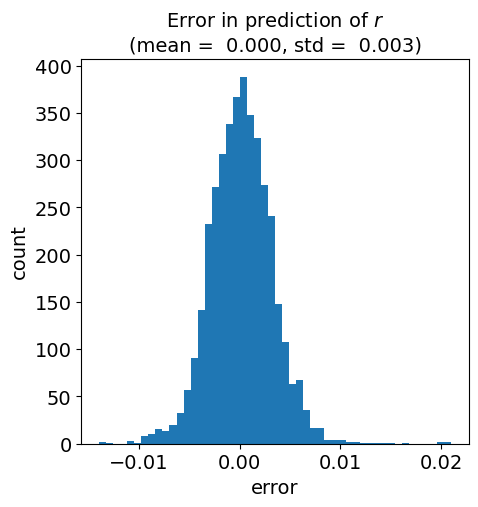

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(r_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $r$' +
    f'\n(mean = {np.mean(r_err):6.3f}, std = {np.std(r_err):6.3f})',
    fontsize=14,
)

### 4.3.2 Error in linear model of $n_y$

In [107]:
p_B_T = np.array([-1.2, 1.2, 0.])
p_drone = np.block([[p_x], [p_y], [p_z]]).T
p_drone

array([[-1.33958533,  0.60875549,  0.02183903],
       [-1.33751507,  0.60821712,  0.02183849],
       [-1.33675661,  0.60831873,  0.02184327],
       ...,
       [-1.40128772,  0.64261309,  0.31169999],
       [-1.39946954,  0.64040573,  0.31053392],
       [-1.39752998,  0.63928382,  0.30937805]])

In [108]:
d_predicted = np.array([np.linalg.norm(p - p_B_T) for p in p_drone])
d_err = d_predicted - d

Text(0.5, 0, 'time (s)')

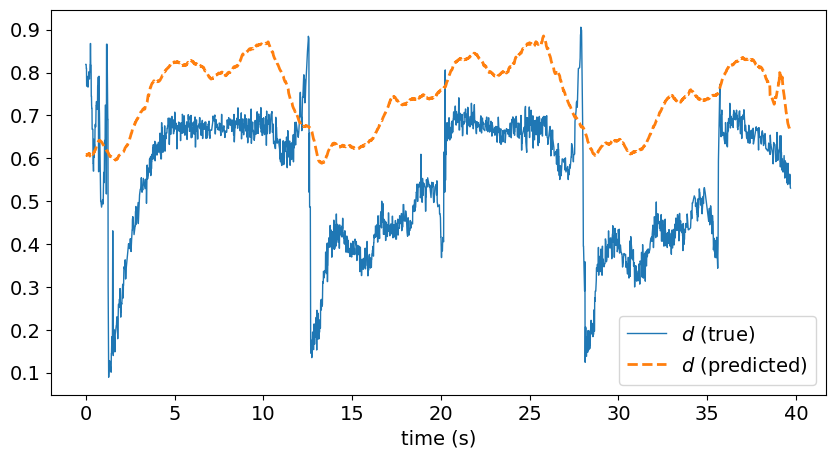

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, d, label=r'$d$ (true)', linewidth=1)
ax.plot(t, d_predicted, '--', label=r'$d$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Text(0.5, 1.0, 'Error in prediction of $d$\n(mean =  0.194, std =  0.107)')

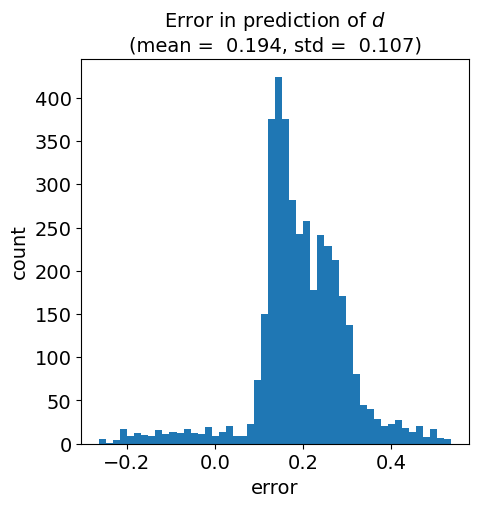

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(d_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $d$' +
    f'\n(mean = {np.mean(d_err):6.3f}, std = {np.std(d_err):6.3f})',
    fontsize=14,
)

In [ ]:
p_x_t_dot_err = p_x_dot_err

data_list = [p_z_dot_err, theta_dot_err, phi_dot_err, v_x_dot_err, v_y_dot_err, v_z_dot_err, p_x_t_dot_err]
sensor_data = [n_x_err, n_y_err, r_err, d_err]

print("State variances:")
for i in range(6):
    print(np.var(data_list[i]))

print("Sensor variances:")
for i in range(4):
    print(np.var(sensor_data[i]))

State variances:
0.0035814516856510466
0.0009698012120159652
0.001271255869645765
0.030357003666006844
0.03689471495632531
0.1042045896025558
Sensor variances:
2.1697084358332304
3.1529563907970957
9.74416462829427e-06
0.011345858577993657


In [80]:
# A_num = sym.lambdify(['g', 'k_flow', 'p_z_eq', 'd'], A)(g, k_flow, p_z_eq, d_eq).astype(np.float64)
# B_num = sym.lambdify(['g', 'k_flow', 'p_z_eq', 'd'], B)(g, k_flow, p_z_eq, d_eq).astype(np.float64)
# C_num = sym.lambdify(['g', 'k_flow', 'p_z_eq', 'd'], C)(g, k_flow, p_z_eq, d_eq).astype(np.float64)
# D_num = sym.lambdify(['g', 'k_flow', 'p_z_eq', 'd'], D)(g, k_flow, p_z_eq, d_eq).astype(np.float64)

# Check that all numbers in model are finite (i.e., not Inf, not NaN)
# assert(np.all(np.isfinite(A_num)))
# assert(np.all(np.isfinite(B_num)))
# assert(np.all(np.isfinite(C_num)))
# assert(np.all(np.isfinite(D_num)))

# Write model to file
with open('model.json', 'w') as f:
    json.dump(
        {
            'A': A.tolist(),
            'B': B.tolist(),
            'C': C.tolist(),
            'D': D.tolist(),
            'g': g,
            'k_flow': k_flow,
            'p_z_eq': p_z_eq,
            'r_s_eq' : r_s_eq
        },
        f,
        sort_keys=False,
        indent='\t'
    )